# Preliminaries

In [1]:
import random
import os
from copy import deepcopy

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymnet

In [2]:
%matplotlib inline

In [3]:
data_path = 'multiplex_embeddings_data'
datasets_layer_description = {  # {dataset: [layer_1 description, layer_2 description, ...]}
    'Air_Train': [
        'Air network',
        'Train network',
    ],
    'arXiv': [
        'physics.bioph category',
        'cond-mat.disnn category',
        'physics.soc-ph',
        'physics.data-an category',
        'math.OC category',
        'cond-mat.stat-mech category',
        'q-bio.MN category',
        'cs.SI category',
    ],
    'C. Elegans Connectomme': [
        'Electric',
        'Chemical Monadic',
        'Chemical Polyadic',
    ],
    'Drosophila Melanogaster': [  # meh
        'suppressive genetic interaction',
        'additive genetic interaction',
    ],
    'Human Brain': [
        'structural brain network',
        'functional brain network',
    ],
    'IPv4_IPv6 Internet': [  # meh
        'IPv4 topology',
        'IPv6 topology',
    ],
    'Physicians': [
        'advice',
        'discussion',
        'friendship',
    ],
    'Rattus': [  # meh
        'physical association',
        'direct interaction',
    ],
    'SacchPomb': [
        'direct interaction',
        'colocalization',
        'physical association',
        'synthetic genetic interaction',
        'association',
    ],
    'London_Multiplex_Transport': [
        'Tube (All underground lines aggregated)',
        'Overground',
        'DLR',
    ],
    'NYClimateMarch2014_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'Cannes2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'MoscowAthletics2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'MLKing2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'ObamaInIsrael2013_Multiplex_Social': [
        'RT',
        'MT',
        'RE',
    ],
    'CS-Aarhus_Multiplex_Social': [
        'lunch',
        'facebook',
        'coauthor',
        'leisure',
        'work',
    ],
    'Arabidopsis_Multiplex_Genetic': [
        'direct_interaction',
        'physical_association',
        'additive_genetic_interaction_defined_by_inequality',
        'suppressive_genetic_interaction_defined_by_inequality',
        'synthetic_genetic_interaction_defined_by_inequality',
        'association',
        'colocalization',
    ],
    'Bos_Multiplex_Genetic': [
        'physical_association',
        'association',
        'direct_interaction',
        'colocalization',
    ],
    'Celegans_Multiplex_Genetic': [
        'direct_interaction',
        'physical_association',
        'additive_genetic_interaction_defined_by_inequality',
        'suppressive_genetic_interaction_defined_by_inequality',
        'association',
        'colocalization',
    ],
    'Drosophila_Multiplex_Genetic': [
        'direct_interaction',
        'suppressive_genetic_interaction_defined_by_inequality',
        'additive_genetic_interaction_defined_by_inequality',
        'physical_association',
        'colocalization',
        'association',
        'synthetic_genetic_interaction_defined_by_inequality',
    ],
    'SacchCere_Multiplex_Genetic': [
        'physical_association',
        'suppressive_genetic_interaction_defined_by_inequality',
        'direct_interaction',
        'synthetic_genetic_interaction_defined_by_inequality',
        'association',
        'colocalization',
        'additive_genetic_interaction_defined_by_inequality',
    ],
    'YeastLandscape_Multiplex_Genetic': [
        'positive_interactions',
        'negative_interactions',
        'positive_correlations',
        'negative_correlations',
    ],
    'CovMulNet19': [
        'COVID19-GDDS332',
        'COVID19-GDDS457',
    ],
}
dataset_names = list(datasets_layer_description.keys())
datasets_layer_description, dataset_names

({'Air_Train': ['Air network', 'Train network'],
  'arXiv': ['physics.bioph category',
   'cond-mat.disnn category',
   'physics.soc-ph',
   'physics.data-an category',
   'math.OC category',
   'cond-mat.stat-mech category',
   'q-bio.MN category',
   'cs.SI category'],
  'C. Elegans Connectomme': ['Electric',
   'Chemical Monadic',
   'Chemical Polyadic'],
  'Drosophila Melanogaster': ['suppressive genetic interaction',
   'additive genetic interaction'],
  'Human Brain': ['structural brain network', 'functional brain network'],
  'IPv4_IPv6 Internet': ['IPv4 topology', 'IPv6 topology'],
  'Physicians': ['advice', 'discussion', 'friendship'],
  'Rattus': ['physical association', 'direct interaction'],
  'SacchPomb': ['direct interaction',
   'colocalization',
   'physical association',
   'synthetic genetic interaction',
   'association'],
  'London_Multiplex_Transport': ['Tube (All underground lines aggregated)',
   'Overground',
   'DLR'],
  'NYClimateMarch2014_Multiplex_Social': [

In [4]:
def random_relabel(G):
    nodes = list(G.nodes)
    random.shuffle(nodes)
    return nx.relabel_nodes(G, dict(zip(G.nodes, nodes)))

In [5]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [6]:
def cascade_remove_links(G):

    keep_going = True
    while keep_going:
        keep_going = False

        clusters_in_layers = [list(nx.connected_components(g)) for g in G]

        for i, g in enumerate(G):
            clusters_to_search = clusters_in_layers[:i] + clusters_in_layers[i + 1:]
            for edge in g.edges():
                if any(find_component(edge[0], clusters) != find_component(edge[1], clusters)
                       for clusters in clusters_to_search):
                    keep_going = True
                    g.remove_edge(*edge)
    
    return G

In [7]:
def articulation_points_multiplex(G):
    ap = set(nx.articulation_points(G[0]))
    return ap.union(*[nx.articulation_points(g) for g in G[1:]])

In [8]:
def max_comp(g):
    return max(nx.connected_components(g), key=len)

In [9]:
def remove_ap(G):
    G = cascade_remove_links(G)

    gcc = max_comp(G[0])
    gcc_size = len(gcc)

    for g in G:
        g.remove_nodes_from([n for n in g if n not in gcc])

    art_points = articulation_points_multiplex(G)

    for g in G:
        g.remove_nodes_from(art_points)

    return G, art_points, gcc_size

In [42]:
def draw_two_layer(G_orig, G, layer_labels, figtitle, pos, save=True):
    """Supports only one or two layers
    """
    onet = pymnet.MultiplexNetwork(couplings='categorical')
    for label in layer_labels:
        onet.add_layer(label)
    L = len(layer_labels)

    GRAY = '#84817a'
    BLACK = '#485460'

    art_points = articulation_points_multiplex(G)
    removed = [n for n in G_orig[0] if n not in G[0]]
    node_colors = {(node, layer): 'r'
                   for layer in layer_labels
                   for node in art_points}
    node_colors.update({(node, layer): GRAY
                        for layer in layer_labels
                        for node in removed})
    edge_colors = {}
    edge_alpha = {}
    edge_width = {}

    for n in G_orig[0].nodes:
        onet.add_node(n)
        if L == 2:
            edge_width[((n, layer_labels[0]), (n, layer_labels[1]))] = .2

    for label, g in zip(layer_labels, G_orig):
        for e1, e2 in g.edges:
            onet[e1, e2, label] = 1
            if e1 in removed or e2 in removed:
                # edge_colors[((e1, 'Facebook'), (e2, 'Facebook'))] = GRAY
                edge_alpha[((e1, label), (e2, label))] = .3
                # edge_width[((e1, 'Facebook'), (e2, 'Facebook'))] = .2
            else:
                # edge_width[((e1, 'Facebook'), (e2, 'Facebook'))] = .5
                edge_colors[((e1, label), (e2, label))] = BLACK

    fig = pymnet.draw(
        onet,
        elev=20,
        layergap=1.35,
        # layershape='circle',
        # figsize=(24, 8),
        nodeLabelRule={},
        nodeColorDict=node_colors,
        edgeColorDict=edge_colors,
        edgeAlphaDict=edge_alpha,
        defaultEdgeWidth=.2,
        # edgeWidthDict=edge_width,
        # defaultLayerColor='#81ecec',
        # defaultLayerColor='#dff9fb',
        defaultLayerColor='#e8f8f8',
        nodeCoords=pos,
        camera_dist=10,
    )
    if save:
        fig.savefig(figtitle)

In [43]:
def draw_process(G, pos, layer_labels, figtitle, save=True):
    plt.close()
    G_orig = deepcopy(G)
    it = 0

    while True:
        G = cascade_remove_links(G)

        gcc = max_comp(G[0])

        for g in G:
            g.remove_nodes_from([n for n in g if n not in gcc])

        draw_two_layer(G_orig, G, layer_labels, f'{figtitle}_{it}.pdf', pos, save=save)
        it += 1

        art_points = articulation_points_multiplex(G)
        for g in G:
            g.remove_nodes_from(art_points)
        if not art_points:
            break

In [44]:
plt.close('all')

# Load dataset

In [45]:
len(dataset_names)

23

In [46]:
dataset_name = dataset_names[15]
random_relabeling = False

In [47]:
print(f'Loading {dataset_name}')
path = os.path.join(data_path, dataset_name)

layer_paths = [os.path.join(path, f'l_{i}.txt')
                for i in range(1, len(datasets_layer_description[dataset_name]) + 1)]
G_loaded = [nx.read_edgelist(
        layer_path,
        create_using=nx.Graph,
        nodetype=int,
    ) for layer_path in layer_paths]

if random_relabeling:
    for i, g in enumerate(G_loaded[1:]):
        G_loaded[i + 1] = random_relabel(g)
print(*G_loaded, sep='\n')

Loading CS-Aarhus_Multiplex_Social
Graph with 60 nodes and 193 edges
Graph with 32 nodes and 124 edges
Graph with 25 nodes and 21 edges
Graph with 47 nodes and 88 edges
Graph with 60 nodes and 194 edges


# Preprocessing

In [48]:
G = [g for g in G_loaded if len(g) > 50]
# G = [g for g in G_loaded if len(g.edges) > 8000]
print(*G, sep='\n')

Graph with 60 nodes and 193 edges
Graph with 60 nodes and 194 edges


In [31]:
for g in G:
    g.remove_nodes_from([n for n in g if len(g[n]) < 3])
print(*G, sep='\n')

Graph with 56 nodes and 188 edges
Graph with 50 nodes and 175 edges


In [49]:
possible_nodes = set(G[0].nodes).union(
    *(set(g.nodes) for g in G[1:]),
)
real_nodes = possible_nodes.intersection(*(g.nodes for g in G))

print(f'Only {len(real_nodes)} real nodes that are present in all layers')

Only 59 real nodes that are present in all layers


In [50]:
print(f'Dropping {len(possible_nodes) - len(real_nodes)} redundant nodes')
for g in G:
    g.remove_nodes_from([n for n in g if n not in real_nodes])

Dropping 2 redundant nodes


Layer 1:
  Size: 59
  Edges: 191
  Mean degree: 6.47457627118644
Layer 2:
  Size: 59
  Edges: 192
  Mean degree: 6.508474576271187


C:\Users\kuzne\AppData\Local\Temp\ipykernel_21460\105835110.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


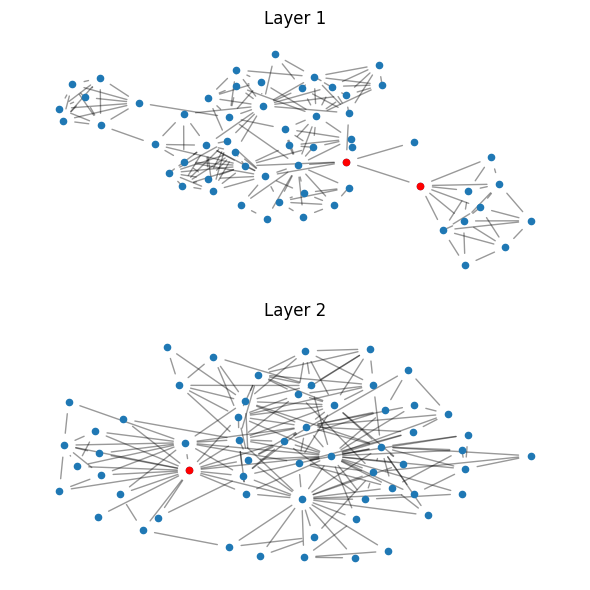

In [51]:
fig, ax = plt.subplots(nrows=len(G), ncols=1, figsize=(6, 3 * len(G)))
for i, g in enumerate(G):

    print(f'Layer {i + 1}:')
    print(f'  Size: {len(g)}')
    print(f'  Edges: {len(g.edges)}')

    degree_sequence = sorted((d for _, d in g.degree), reverse=True)
    print(f'  Mean degree: {np.mean(degree_sequence)}')

    # sorted_nodes = sorted(g.nodes)
    # mn, mx = sorted_nodes[0], sorted_nodes[-1]
    # if all(n1 == n2 for n1, n2 in zip(sorted_nodes, range(mn, mx + 1))):
    # # if sorted_nodes == list(range(mn, mx + 1)):
    #     print(f'  Nodes are labeled through {mn}:{mx}')
    # else:
    #     gaps = [n for n in range(mn, mx + 1) if n not in sorted_nodes]
    #     print(f'  Nodes are labeled through {mn}:{mx} with {len(gaps)} gaps {gaps}')
    
    # ax[i, 0].set_title('Degree distribution')
    # ax[i, 0].bar(*np.unique(degree_sequence, return_counts=True), width=.8)

    # ax[i, 1].set_title('Degree distribution (log)')
    # ax[i, 1].hist(degree_sequence, bins=np.logspace(np.log10(1), np.log10(len(g)), num=len(g)), rwidth=.8)
    # # ax[i, 1].hist(degree_sequence, bins=len(g), rwidth=.8)
    # ax[i, 1].set_xscale('log')
    # ax[i, 1].set_yscale('log')
    # # ax2.plot(np.exp(np.arange(1, np.log10(len(G)))), 1000 - 2.5 * np.exp(np.arange(1, np.log10(len(G)))))

    if len(g) < 1000:
        ax[i].set_title(f'Layer {i + 1}')
        # gcc = g.subgraph(sorted(nx.connected_components(g), key=len, reverse=True)[0])
        pos = nx.kamada_kawai_layout(g)
        nx.draw_networkx_nodes(g, pos, ax=ax[i], node_size=20)
        ap = nx.articulation_points(g)
        nx.draw_networkx_nodes(g.subgraph(ap), pos, ax=ax[i], node_size=20, node_color='r')
        nx.draw_networkx_edges(g, pos, ax=ax[i], alpha=.4, arrows=True)
        ax[i].set_axis_off()

fig.tight_layout()
fig.show()

# Experiment

In [26]:
G, ap, gcc_size = remove_ap(G)
G, ap, len(ap), gcc_size


([<networkx.classes.graph.Graph at 0x1b9a568ef20>,
 set(),
 0,
 1)

In [37]:
for i, g in enumerate(G):
    g = nx.relabel_nodes(g, dict(zip(G[0].nodes, range(len(G[0])))))
    nx.write_edgelist(g, f'cpp_data/l_{i + 1}.txt', data=False)

# Plots

In [67]:
G = [
    nx.Graph([
        (0, 1), (0, 2), (1, 3), (2, 3), (3, 4), (3, 5),
        (4, 7), (4, 6), (5, 6), (5, 8), (6, 7), (6, 8), (7, 9), (8, 9),
        (0, 3), (3, 6), (6, 9),
    ]),
    nx.Graph([
        (0, 1), (0, 2), (1, 3), (2, 3), (3, 4), (3, 5), (1, 4), (2, 5),
        (4, 6), (5, 6), (6, 7), (6, 8), (7, 9), (8, 9),
        (0, 3), (3, 6), (6, 9),
    ]),
]

In [68]:
G = [G[0]]

In [69]:
# pos = nx.kamada_kawai_layout(G[0])
# pos = nx.circular_layout(G[0])
# pos = nx.planar_layout(G[0])
# pos = nx.shell_layout(G[0])
pos = nx.spring_layout(G[0])

In [30]:
# draw_process(G, pos, ['Facebook', 'Lunch'], 'figs/real_multiplex_draw/real_multiplex')
draw_process(G, pos, ['IPv4', 'IPv6'], 'figs/internet')

NameError: name 'pos' is not defined

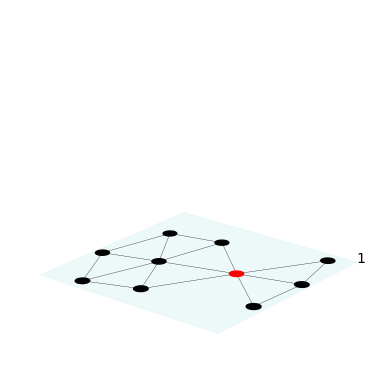

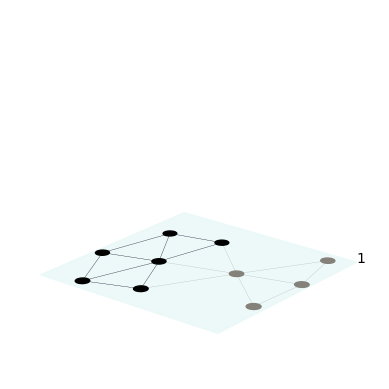

In [70]:
draw_process(
    G, pos,
    [
        '1',
        # '2',
    ],
    # 'figs/toy_example/toy_example',
    'figs/toy_example/toy_example_1',
)